In [83]:
import pandas as pd

df = pd.read_csv('train_data_categories.csv')
df = df.drop(298)

In [84]:
df['text'] = df['title']
X = df['text']

In [85]:
df['tags'] = df['tags'].apply(lambda x: x.split(':')[0].strip())
df['tags_list'] = df['tags'].apply(lambda x: [item.strip().lower() for item in x.split(',')])

In [86]:
from collections import Counter

all_tags = [tag for sublist in df['tags_list'] for tag in sublist]
tag_counts = Counter(all_tags)

MIN_TAG_COUNT = 10
common_tags = {tag for tag, count in tag_counts.items() if count >= MIN_TAG_COUNT}
df['filtered_tags'] = df['tags_list'].apply(lambda x: [tag for tag in x if tag in common_tags])

In [87]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
Y_binary = mlb.fit_transform(df['filtered_tags'])
Y = pd.DataFrame(Y_binary, columns=mlb.classes_)

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=500)
X_vectorized = vectorizer.fit_transform(X)

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_vectorized, Y, test_size=0.2)

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import numpy as np

models = {
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(C=10, max_iter=1000, solver='liblinear')),
    "XGBoost": XGBClassifier(),
}

for name, model in models.items():
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='micro', zero_division=0)
    print(f"{name}: Accuracy = {acc:.4}, F1 = {f1:.4}")
    report = classification_report(
        Y_test,
        Y_pred,
        target_names=mlb.classes_,
        zero_division=0
    )
    print(report)

Random Forest: Accuracy = 0.6762, F1 = 0.7845
Logistic Regression: Accuracy = 0.6381, F1 = 0.7623
XGBoost: Accuracy = 0.6095, F1 = 0.7276


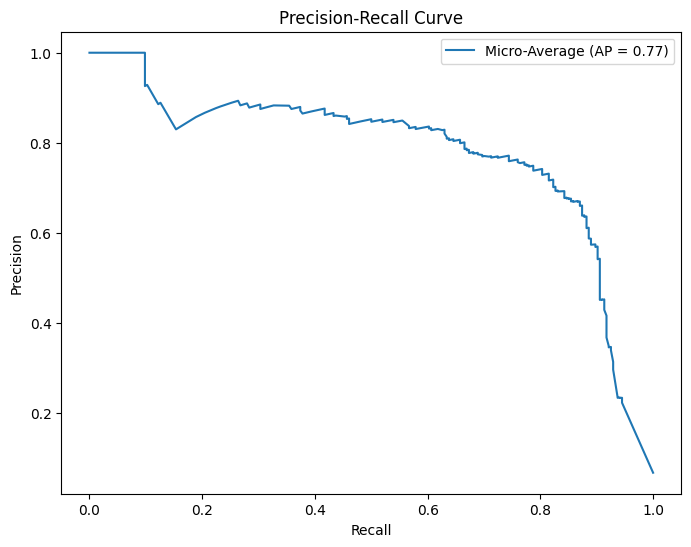

In [ ]:
model = RandomForestClassifier(n_estimators=200)

Y_proba = model.predict_proba(X_test)
Y_proba_matrix = np.array(Y_proba)[:, :, 1].T

precision, recall, _ = precision_recall_curve(Y_test.values.ravel(), Y_proba_matrix.ravel())
avg_precision = average_precision_score(Y_test, Y_proba_matrix, average='micro')

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Micro-Average (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

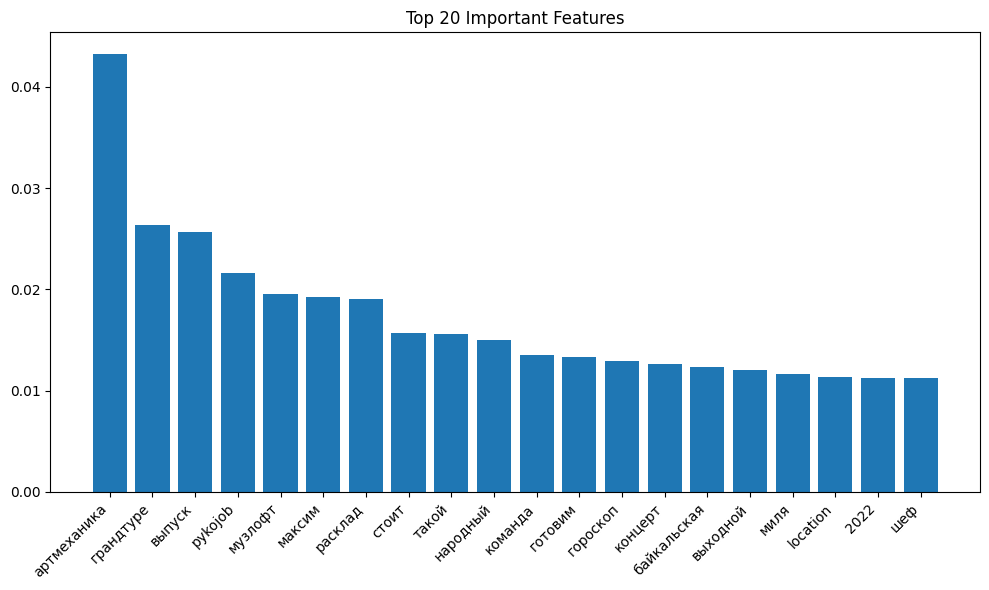

In [ ]:
model = models["Random Forest"]
importances = model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[indices], align='center')
plt.xticks(range(20), feature_names[indices], rotation=45, ha='right')
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.show()

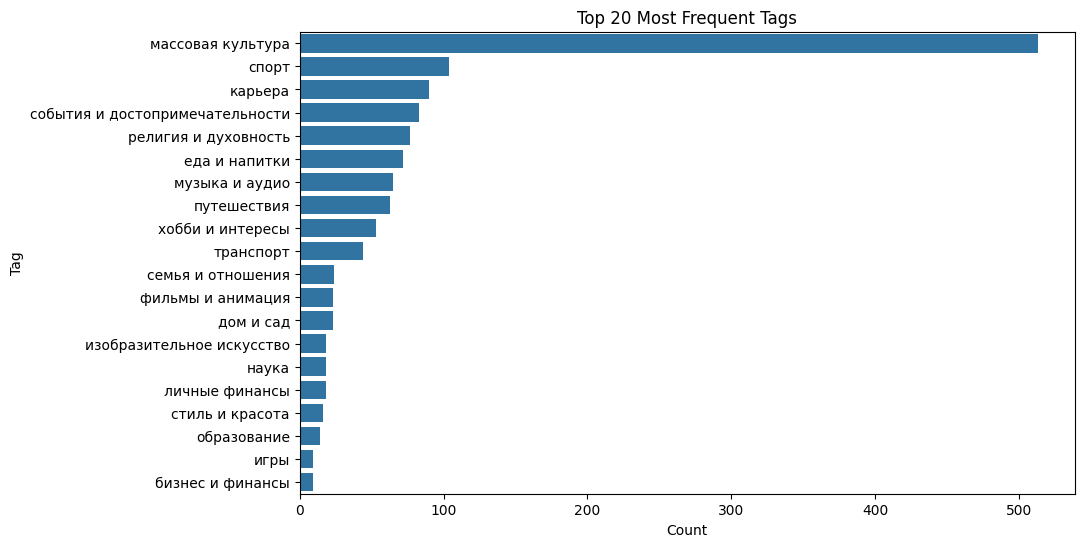

In [ ]:
tag_counts_df = pd.DataFrame(tag_counts.most_common(20), columns=['Tag', 'Count'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Tag', data=tag_counts_df)
plt.title('Top 20 Most Frequent Tags')
plt.show()

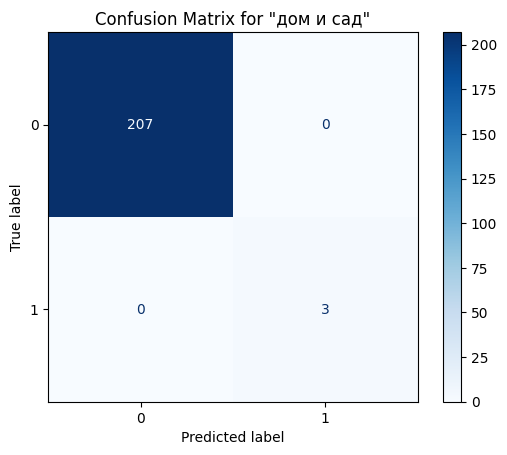

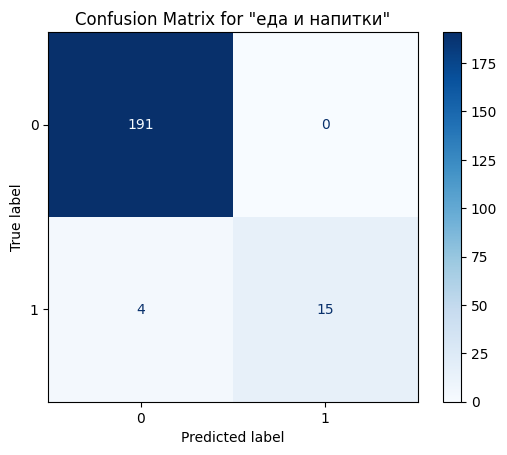

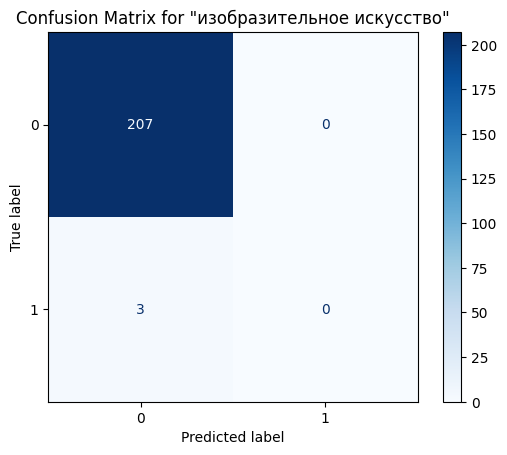

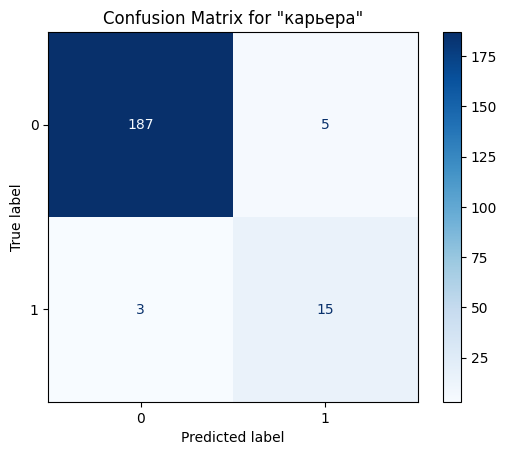

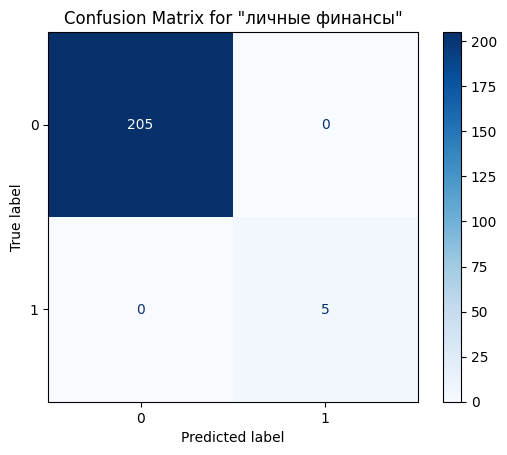

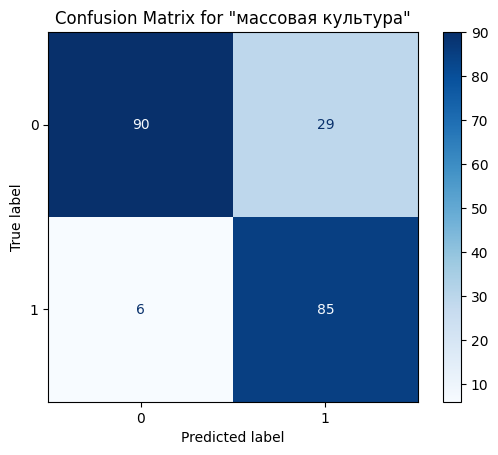

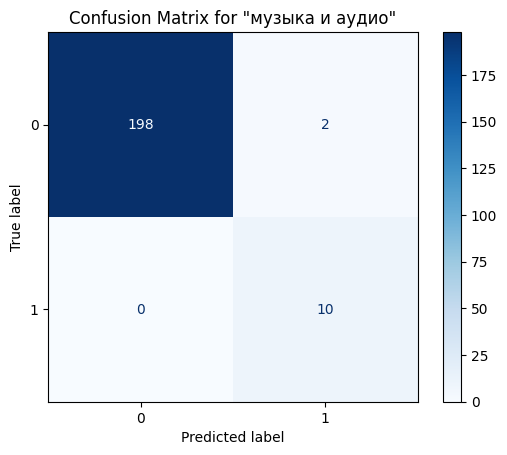

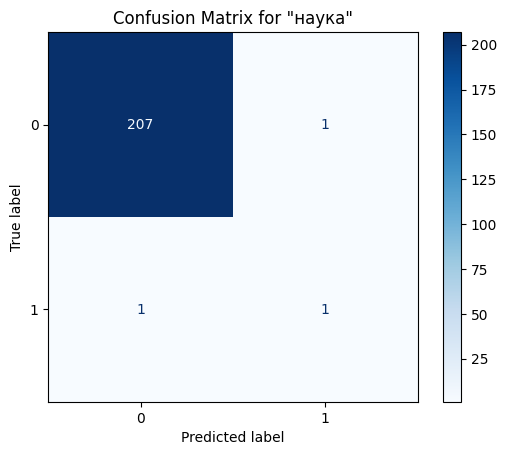

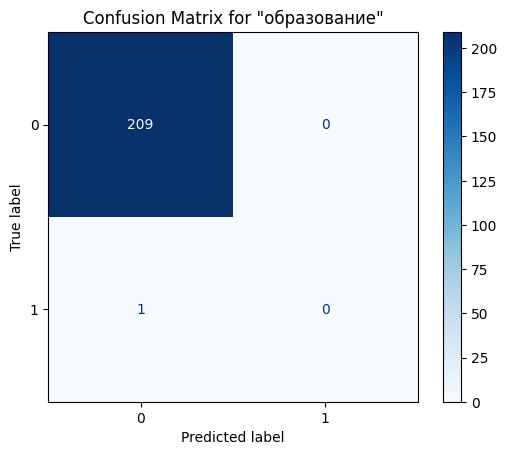

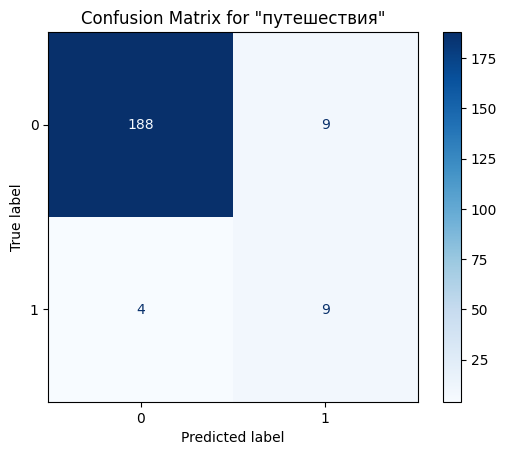

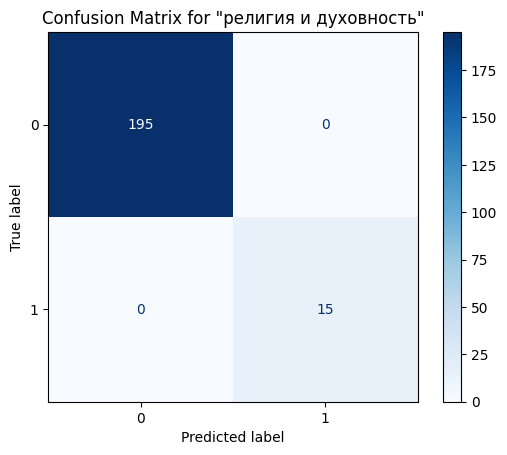

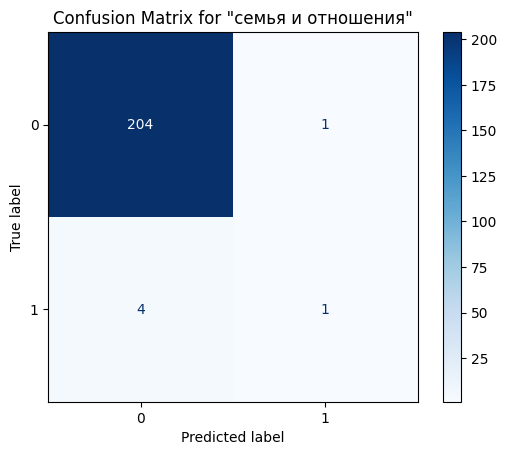

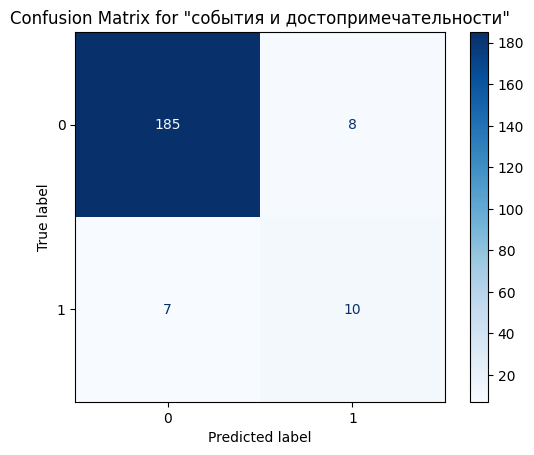

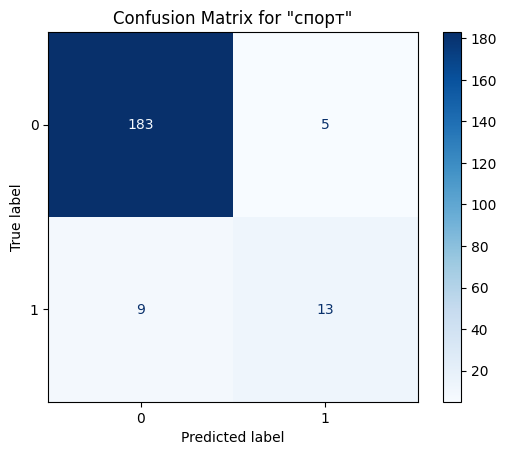

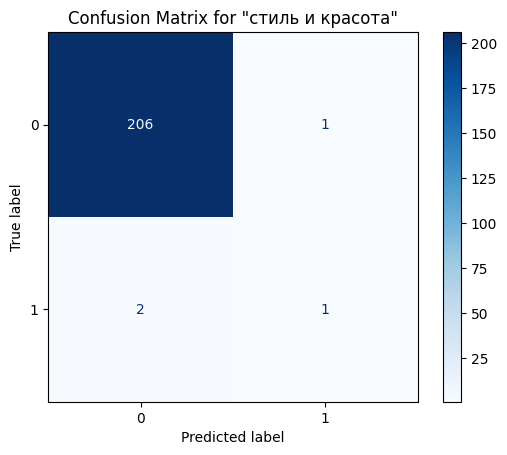

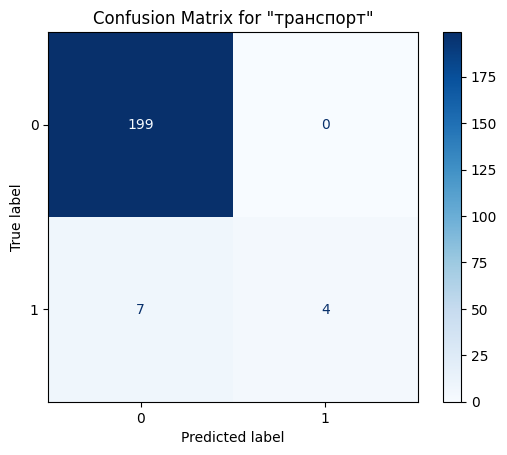

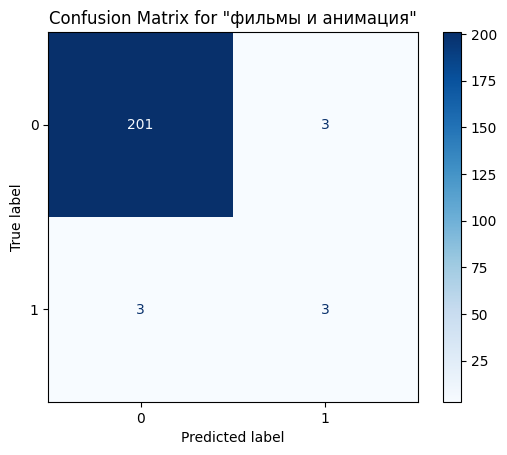

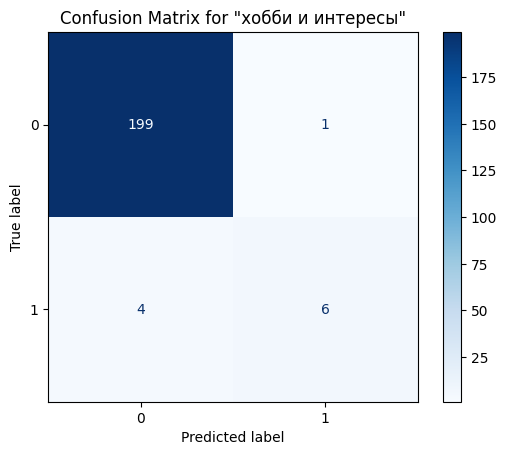

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

for i in range(len(Y.columns)):
  tag = Y.columns[i]
  y_true_tag = Y_test[tag]
  y_pred_tag = Y_pred[:, Y.columns.get_loc(tag)]

  ConfusionMatrixDisplay.from_predictions(y_true_tag, y_pred_tag, cmap='Blues')
  plt.title(f'Confusion Matrix for "{tag}"')
  plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200)
model.fit(X_vectorized, Y)

RandomForestClassifier(n_estimators=200)

In [ ]:
def predict_tags(title, description):
  text = title
  X_cur = vectorizer.transform([text])
  Y_cur = model.predict(X_cur)[0]
  tags = []
  for i, tag in enumerate(mlb.classes_):
    if Y_cur[i]:
      tags.append(tag)
  return tags

In [ ]:
mlb.classes_

array(['дом и сад', 'еда и напитки', 'изобразительное искусство',
       'карьера', 'личные финансы', 'массовая культура', 'музыка и аудио',
       'наука', 'образование', 'путешествия', 'религия и духовность',
       'семья и отношения', 'события и достопримечательности', 'спорт',
       'стиль и красота', 'транспорт', 'фильмы и анимация',
       'хобби и интересы'], dtype=object)

In [ ]:
predict_tags('Такой расклад. Узнайте у рун подробности о задуманном!', '...')

['религия и духовность']

In [ ]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)